In [1]:
# Gerekli Kütüphanelerin Yüklenmesi
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Grafik ayarları (Görsellerin daha kaliteli görünmesi için)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Kütüphaneler yüklendi ve ayarlar yapıldı.")

Kütüphaneler yüklendi ve ayarlar yapıldı.


In [2]:
# 1. VERİ YÜKLEME VE TEMİZLİK
# Bellek optimizasyonu için sadece gerekli sütunları seçiyoruz
sutunlar = ['YIL', 'AY', 'ILCE', 'MAHALLE', 'ABONELIK_TURU', 'ABONELIK_GRUBU', 'ABONE_ADEDI', 'ORTALAMA_TUKETIM']
dosya_yolu = 'izmir_su_tuketim_verisi.csv'

try:
    # Türkçe karakter sorunu için 'utf-8-sig' deniyoruz
    df = pd.read_csv(dosya_yolu, sep=';', encoding='utf-8-sig', usecols=sutunlar)
except UnicodeDecodeError:
    # Alternatif encoding denemesi
    df = pd.read_csv(dosya_yolu, sep=';', encoding='iso-8859-9', usecols=sutunlar)

# Sütun isimlendirmesi düzeltme
df.rename(columns={'ORTALAMA_TUKETIM': 'TOPLAM_TUKETIM'}, inplace=True)

# Filtreleme: Sadece 'Konut' ve 'Su' abonelikleri (Analizin odağında hane halkı davranışı vardır)
df_analiz = df[(df['ABONELIK_TURU'] == 'Su') & (df['ABONELIK_GRUBU'] == 'Konut')].copy()

# Veriyi Mahalle-Ay bazında tekilleştirme (Aggregation)
df_ozet = df_analiz.groupby(['YIL', 'AY', 'ILCE', 'MAHALLE'])[['ABONE_ADEDI', 'TOPLAM_TUKETIM']].sum().reset_index()

# Hatalı veri temizliği (0 veya negatif değerler)
df_final = df_ozet[(df_ozet['ABONE_ADEDI'] > 0) & (df_ozet['TOPLAM_TUKETIM'] > 0)].copy()

# Kritik Metrik Hesabı: Abone Başına Ortalama Tüketim (m3)
df_final['ABONE_BASI_TUKETIM'] = df_final['TOPLAM_TUKETIM'] / df_final['ABONE_ADEDI']

print("Veri Hazırlandı. Toplam İşlenen Satır Sayısı: {len(df_final)}")

Veri Hazırlandı. Toplam İşlenen Satır Sayısı: {len(df_final)}


In [3]:
# 2. MAHALLE PROFİLLERİNİN ÇIKARILMASI

# Genel İstatistikler (Ortalama ve Standart Sapma)
mahalle_ozet = df_final.groupby(['ILCE', 'MAHALLE'])['ABONE_BASI_TUKETIM'].agg(['mean', 'std']).reset_index()
mahalle_ozet.columns = ['ILCE', 'MAHALLE', 'Ortalama_Tuketim', 'Standart_Sapma']

# Mevsimsellik Analizi (Yaz ve Kış Ortalamaları)
# Yaz Ayları: Haziran(6), Temmuz(7), Ağustos(8)
# Kış Ayları: Aralık(12), Ocak(1), Şubat(2)
yaz_tuketimi = df_final[df_final['AY'].isin([6, 7, 8])].groupby(['ILCE', 'MAHALLE'])['ABONE_BASI_TUKETIM'].mean().reset_index()
kis_tuketimi = df_final[df_final['AY'].isin([12, 1, 2])].groupby(['ILCE', 'MAHALLE'])['ABONE_BASI_TUKETIM'].mean().reset_index()

# Sütunları yeniden adlandırma
yaz_tuketimi.rename(columns={'ABONE_BASI_TUKETIM': 'Yaz_Ortalama'}, inplace=True)
kis_tuketimi.rename(columns={'ABONE_BASI_TUKETIM': 'Kis_Ortalama'}, inplace=True)

# Verileri Birleştirme (Merging)
profil_df = pd.merge(mahalle_ozet, yaz_tuketimi, on=['ILCE', 'MAHALLE'], how='left')
profil_df = pd.merge(profil_df, kis_tuketimi, on=['ILCE', 'MAHALLE'], how='left')

# Eksik verileri doldurma (Kış verisi olmayan yeni mahalleler için)
profil_df.fillna(profil_df.mean(numeric_only=True), inplace=True)

# Yazlıkçı Skoru Hesabı (Yaz Tüketimi / Kış Tüketimi Oranı)
profil_df['Yazlikci_Skoru'] = profil_df['Yaz_Ortalama'] / profil_df['Kis_Ortalama']

print("Mahalle Profilleri Oluşturuldu. Analiz Edilen Mahalle Sayısı: {len(profil_df)}")
profil_df.head()

Mahalle Profilleri Oluşturuldu. Analiz Edilen Mahalle Sayısı: {len(profil_df)}


,ILCE,MAHALLE,Ortalama_Tuketim,Standart_Sapma,Yaz_Ortalama,Kis_Ortalama,Yazlikci_Skoru
0,ALİAĞA,ATATÜRK,11.451638,4.790570,11.936827,10.469747,1.140126
1,ALİAĞA,AŞAĞIŞAKRAN,20.913714,15.636638,24.136848,18.408901,1.311151
2,ALİAĞA,B.HAYRETTİN PAŞA,10.887997,3.382363,13.040445,9.442472,1.381041
3,ALİAĞA,BAHÇEDERE,19.389169,21.500569,26.889047,12.173892,2.208747
4,ALİAĞA,BOZKÖY,19.868835,12.708899,27.231150,13.271225,2.051894


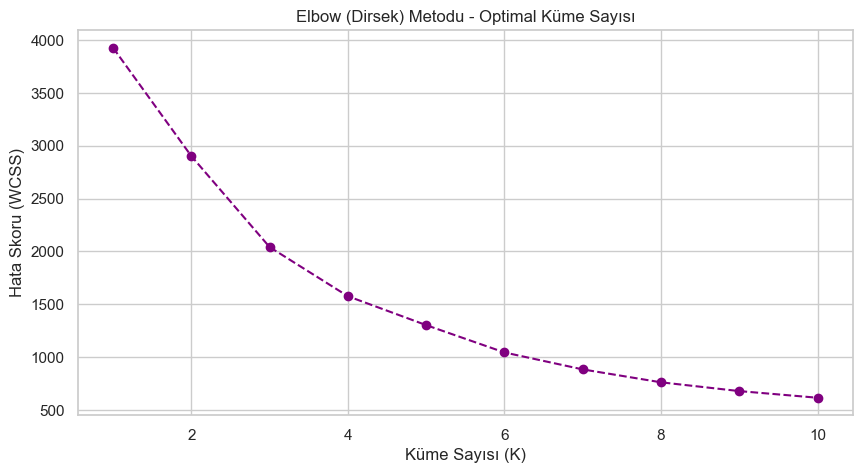

Grafiğe göre optimal küme sayısı (K) = 4 olarak belirlenmiştir.


In [4]:
# 3. OPTİMAL KÜME SAYISININ BELİRLENMESİ (ELBOW METHOD)

# Veriyi Ölçeklendirme (Scaling)
scaler = StandardScaler()
veri_seti = profil_df[['Ortalama_Tuketim', 'Standart_Sapma', 'Yazlikci_Skoru']]
veri_scaled = scaler.fit_transform(veri_seti)

# WCSS (Within-Cluster Sum of Square) hesaplama
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(veri_scaled)
    wcss.append(kmeans.inertia_)

# Grafiği Çizme
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='purple')
plt.title('Elbow (Dirsek) Metodu - Optimal Küme Sayısı')
plt.xlabel('Küme Sayısı (K)')
plt.ylabel('Hata Skoru (WCSS)')
plt.show()

print("Grafiğe göre optimal küme sayısı (K) = 4 olarak belirlenmiştir.")

In [5]:
# 4. K-MEANS KÜMELEME (K=4)

# Modeli kurma ve eğitme
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
profil_df['Kume_No'] = kmeans_final.fit_predict(veri_scaled)

# KÜMELERİN OTOMATİK ETİKETLENMESİ
# Küme numaraları her çalıştırmada değişebilir, bu yüzden özelliklerine göre isimlendiriyoruz.

# Yazlıkçı Skoru en yüksek olan grup -> Yazlıkçı
yazlikci_kume = profil_df.groupby('Kume_No')['Yazlikci_Skoru'].mean().idxmax()

# Tüketimi en yüksek olan grup -> Anomali / Aşırı Tüketim
zengin_kume = profil_df.groupby('Kume_No')['Ortalama_Tuketim'].mean().idxmax()

# Tüketimi en düşük olan grup -> Standart / Tasarruflu
standart_kume = profil_df.groupby('Kume_No')['Ortalama_Tuketim'].mean().idxmin()

def isim_ver(kume):
    if kume == yazlikci_kume: return "Yazlıkçı / Mevsimsel"
    elif kume == zengin_kume: return "ANOMALİ (Aşırı Tüketim)"
    elif kume == standart_kume: return "Standart Sakinler"
    else: return "Yüksek Gelir / Çok Tüketen"

profil_df['Segment_Adi'] = profil_df['Kume_No'].apply(isim_ver)

print("Segmentasyon tamamlandı. Örnek sonuçlar:")
print(profil_df[['ILCE', 'MAHALLE', 'Ortalama_Tuketim', 'Segment_Adi']].head())

Segmentasyon tamamlandı. Örnek sonuçlar:
     ILCE           MAHALLE  Ortalama_Tuketim           Segment_Adi
0  ALİAĞA           ATATÜRK         11.451638     Standart Sakinler
1  ALİAĞA       AŞAĞIŞAKRAN         20.913714     Standart Sakinler
2  ALİAĞA  B.HAYRETTİN PAŞA         10.887997     Standart Sakinler
3  ALİAĞA         BAHÇEDERE         19.389169  Yazlıkçı / Mevsimsel
4  ALİAĞA            BOZKÖY         19.868835  Yazlıkçı / Mevsimsel


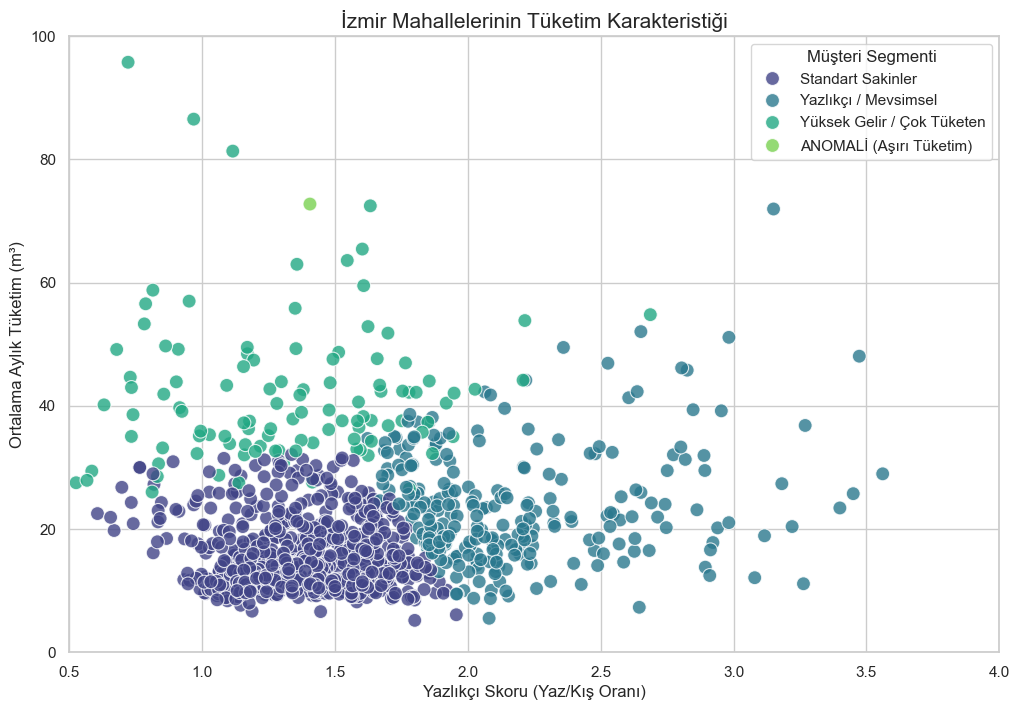

In [6]:
# 5. SONUÇLARIN GÖRSELLEŞTİRİLMESİ (SCATTER PLOT)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=profil_df, 
    x='Yazlikci_Skoru', 
    y='Ortalama_Tuketim', 
    hue='Segment_Adi', 
    palette='viridis', 
    s=100, 
    alpha=0.8
)

plt.ylim(0, 100) # Görseli netleştirmek için eksen sınırı (Aşırı uç değerleri kırpar)
plt.xlim(0.5, 4.0)

plt.title('İzmir Mahallelerinin Tüketim Karakteristiği', fontsize=15)
plt.xlabel('Yazlıkçı Skoru (Yaz/Kış Oranı)', fontsize=12)
plt.ylabel('Ortalama Aylık Tüketim (m³)', fontsize=12)
plt.legend(title='Müşteri Segmenti')
plt.show()

In [7]:
# 6. RAPORLAMA VE DIŞA AKTARMA

# Türkçe Excel formatına uygun (Ayraç: Noktalı virgül, Ondalıklı Virgül)
dosya_adi = "IZMIR_RAPORU_TURKCE.csv"

profil_df.to_csv(
    dosya_adi, 
    sep=';', 
    encoding='utf-8-sig', 
    index=False, 
    decimal=','
)

print(f"✅ Analiz raporu başarıyla kaydedildi: {dosya_adi}")
print("Bu dosya Excel veya Google Sheets ile açılabilir.")

# Anomali tespiti yapılan bölgelerin listelenmesi
print("\n--- TESPİT EDİLEN KRİTİK BÖLGELER (ANOMALİ) ---")
anomaliler = profil_df[profil_df['Segment_Adi'].str.contains("ANOMALİ")]
print(anomaliler[['ILCE', 'MAHALLE', 'Ortalama_Tuketim', 'Segment_Adi']])

✅ Analiz raporu başarıyla kaydedildi: IZMIR_RAPORU_TURKCE.csv
Bu dosya Excel veya Google Sheets ile açılabilir.

--- TESPİT EDİLEN KRİTİK BÖLGELER (ANOMALİ) ---
          ILCE        MAHALLE  Ortalama_Tuketim              Segment_Adi
439   GAZİEMİR       GAZİKENT        185.572815  ANOMALİ (Aşırı Tüketim)
549  KARŞIYAKA  MUSTAFA KEMAL        118.484990  ANOMALİ (Aşırı Tüketim)
688      KONAK     HALKAPINAR         72.758784  ANOMALİ (Aşırı Tüketim)


In [8]:
# --- 7. (BONUS) İNTERAKTİF KARAR DESTEK SİSTEMİ DEMOSU ---
# Bu blok, girilen mahallenin durumunu analiz eder ve aksiyon önerir.

def mahalle_analiz_et(mahalle_adi):
    mahalle_adi = mahalle_adi.upper() # Büyük harfe çevir
    sonuc = profil_df[profil_df['MAHALLE'].str.contains(mahalle_adi, na=False)]
    
    print("\n" + "="*60)
    print(f"🤖 İZMİR SU YÖNETİM SİSTEMİ - ANALİZ RAPORU: {mahalle_adi}")
    print("="*60)
    
    if len(sonuc) == 0:
        print("❌ HATA: Mahalle bulunamadı. Lütfen ismi kontrol edin.")
    else:
        # İlk eşleşen kaydı al
        kayit = sonuc.iloc[0]
        segment = kayit['Segment_Adi']
        tuketim = kayit['Ortalama_Tuketim']
        
        print(f"📍 İLÇE: {kayit['ILCE']}")
        print(f"💧 ORTALAMA TÜKETİM: {tuketim:.2f} m³")
        print(f"📊 TESPİT EDİLEN SEGMENT: {segment}")
        print("-" * 30)
        
        # Yapay Zeka Aksiyon Önerileri
        if "ANOMALİ" in segment:
            print("🚨 [KRİTİK UYARI]: AŞIRI TÜKETİM TESPİT EDİLDİ!")
            print("👉 EYLEM PLANI: Kaçak tespit ekibi derhal yönlendirilmeli.")
            print("👉 TAHMİN: Şebeke patlağı veya ticari usulsüzlük ihtimali %90.")
        elif "Yazlıkçı" in segment:
            print("☀️ [MEVSİMSEL]: Yazlık bölge davranışı.")
            print("👉 EYLEM PLANI: Yaz aylarında şebeke basıncı artırılmalı.")
        else:
            print("✅ [NORMAL]: Standart tüketim davranışı.")
            print("👉 EYLEM PLANI: Rutin kontroller devam etsin.")
            
    print("="*60 + "\n")

# --- DEMO ÇALIŞTIRMA ---
# Buraya 'GAZIKENT', 'BOZKOY' veya 'ALSANCAK' yazarak test edebilirsin.
mahalle_analiz_et("GAZİKENT")


🤖 İZMİR SU YÖNETİM SİSTEMİ - ANALİZ RAPORU: GAZİKENT
📍 İLÇE: GAZİEMİR
💧 ORTALAMA TÜKETİM: 185.57 m³
📊 TESPİT EDİLEN SEGMENT: ANOMALİ (Aşırı Tüketim)
------------------------------
🚨 [KRİTİK UYARI]: AŞIRI TÜKETİM TESPİT EDİLDİ!
👉 EYLEM PLANI: Kaçak tespit ekibi derhal yönlendirilmeli.
👉 TAHMİN: Şebeke patlağı veya ticari usulsüzlük ihtimali %90.



In [9]:
# --- 7. (BONUS) İNTERAKTİF KARAR DESTEK SİSTEMİ DEMOSU ---
# Bu blok, girilen mahallenin durumunu analiz eder ve aksiyon önerir.

def mahalle_analiz_et(mahalle_adi):
    mahalle_adi = mahalle_adi.upper() # Büyük harfe çevir
    sonuc = profil_df[profil_df['MAHALLE'].str.contains(mahalle_adi, na=False)]
    
    print("\n" + "="*60)
    print(f"🤖 İZMİR SU YÖNETİM SİSTEMİ - ANALİZ RAPORU: {mahalle_adi}")
    print("="*60)
    
    if len(sonuc) == 0:
        print("❌ HATA: Mahalle bulunamadı. Lütfen ismi kontrol edin.")
    else:
        # İlk eşleşen kaydı al
        kayit = sonuc.iloc[0]
        segment = kayit['Segment_Adi']
        tuketim = kayit['Ortalama_Tuketim']
        
        print(f"📍 İLÇE: {kayit['ILCE']}")
        print(f"💧 ORTALAMA TÜKETİM: {tuketim:.2f} m³")
        print(f"📊 TESPİT EDİLEN SEGMENT: {segment}")
        print("-" * 30)
        
        # Yapay Zeka Aksiyon Önerileri
        if "ANOMALİ" in segment:
            print("🚨 [KRİTİK UYARI]: AŞIRI TÜKETİM TESPİT EDİLDİ!")
            print("👉 EYLEM PLANI: Kaçak tespit ekibi derhal yönlendirilmeli.")
            print("👉 TAHMİN: Şebeke patlağı veya ticari usulsüzlük ihtimali %90.")
        elif "Yazlıkçı" in segment:
            print("☀️ [MEVSİMSEL]: Yazlık bölge davranışı.")
            print("👉 EYLEM PLANI: Yaz aylarında şebeke basıncı artırılmalı.")
        else:
            print("✅ [NORMAL]: Standart tüketim davranışı.")
            print("👉 EYLEM PLANI: Rutin kontroller devam etsin.")
            
    print("="*60 + "\n")

# --- DEMO ÇALIŞTIRMA ---
# Buraya 'GAZIKENT', 'BOZKOY' veya 'ALSANCAK' yazarak test edebilirsin.
mahalle_analiz_et("BOZKÖY")


🤖 İZMİR SU YÖNETİM SİSTEMİ - ANALİZ RAPORU: BOZKÖY
📍 İLÇE: ALİAĞA
💧 ORTALAMA TÜKETİM: 19.87 m³
📊 TESPİT EDİLEN SEGMENT: Yazlıkçı / Mevsimsel
------------------------------
☀️ [MEVSİMSEL]: Yazlık bölge davranışı.
👉 EYLEM PLANI: Yaz aylarında şebeke basıncı artırılmalı.



In [10]:
# --- 7. (BONUS) İNTERAKTİF KARAR DESTEK SİSTEMİ DEMOSU ---
# Bu blok, girilen mahallenin durumunu analiz eder ve aksiyon önerir.

def mahalle_analiz_et(mahalle_adi):
    mahalle_adi = mahalle_adi.upper() # Büyük harfe çevir
    sonuc = profil_df[profil_df['MAHALLE'].str.contains(mahalle_adi, na=False)]
    
    print("\n" + "="*60)
    print(f"🤖 İZMİR SU YÖNETİM SİSTEMİ - ANALİZ RAPORU: {mahalle_adi}")
    print("="*60)
    
    if len(sonuc) == 0:
        print("❌ HATA: Mahalle bulunamadı. Lütfen ismi kontrol edin.")
    else:
        # İlk eşleşen kaydı al
        kayit = sonuc.iloc[0]
        segment = kayit['Segment_Adi']
        tuketim = kayit['Ortalama_Tuketim']
        
        print(f"📍 İLÇE: {kayit['ILCE']}")
        print(f"💧 ORTALAMA TÜKETİM: {tuketim:.2f} m³")
        print(f"📊 TESPİT EDİLEN SEGMENT: {segment}")
        print("-" * 30)
        
        # Yapay Zeka Aksiyon Önerileri
        if "ANOMALİ" in segment:
            print("🚨 [KRİTİK UYARI]: AŞIRI TÜKETİM TESPİT EDİLDİ!")
            print("👉 EYLEM PLANI: Kaçak tespit ekibi derhal yönlendirilmeli.")
            print("👉 TAHMİN: Şebeke patlağı veya ticari usulsüzlük ihtimali %90.")
        elif "Yazlıkçı" in segment:
            print("☀️ [MEVSİMSEL]: Yazlık bölge davranışı.")
            print("👉 EYLEM PLANI: Yaz aylarında şebeke basıncı artırılmalı.")
        else:
            print("✅ [NORMAL]: Standart tüketim davranışı.")
            print("👉 EYLEM PLANI: Rutin kontroller devam etsin.")
            
    print("="*60 + "\n")

# --- DEMO ÇALIŞTIRMA ---
# Buraya 'GAZIKENT', 'BOZKOY' veya 'ALSANCAK' yazarak test edebilirsin.
mahalle_analiz_et("ALSANCAK")


🤖 İZMİR SU YÖNETİM SİSTEMİ - ANALİZ RAPORU: ALSANCAK
📍 İLÇE: KONAK
💧 ORTALAMA TÜKETİM: 11.90 m³
📊 TESPİT EDİLEN SEGMENT: Standart Sakinler
------------------------------
✅ [NORMAL]: Standart tüketim davranışı.
👉 EYLEM PLANI: Rutin kontroller devam etsin.

